# Whale Flukes

    Moses Kim
    Start: December 25th at 7:10PM EST
    End: December 26th at 5:50PM EST

We are given the task of classifying whales given images of their flukes. As we will see in the later sections it is a more complicated task than just meets the eye. Because of the few number of samples per label we must take a different approach than constructing a CNN to fit to augmented data, which inevitably leads to overfitting. Applying a simple KNN will most likely have high bias since distance between images is not translation invariant. Following the ideas of the paper listed below, we will combine CNN together with KNN in a more sophisticated framework known as SNN (Siamese Neural Network). Rather than generating batches of single images, we generate pairs and learn the same set of weights

<ul>    
    http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf 
</ul>    

## Load Packages and Label Data

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import vgg16

Using TensorFlow backend.


In [2]:
#loading the labels
train_labels = pd.read_csv('train.csv')
train_labels.shape

(9850, 2)

### Data Exploration

In [3]:
train_labels.columns
print("There are {} species of whales we must classify".format(len(train_labels.Id.value_counts())))

There are 4251 species of whales we must classify


Given the number of images, on average, we have a few images per label. This is not good news since we need at least a few hundred, if not thousand, images per label. Let's see if there is any skew in our data.

Text(0, 0.5, 'No. of Labels with k images')

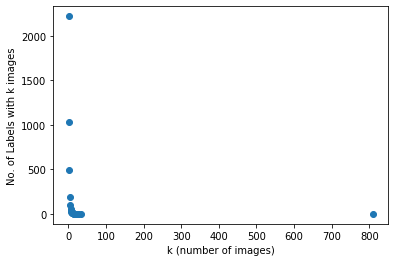

In [4]:
from collections import Counter
#we can use a counter to see the distribution of labels by number of images
label_counts = train_labels['Id'].value_counts()
label_counter_dict = dict(Counter(label_counts))
label_counter_dict.keys()

plt.scatter(x=label_counter_dict.keys(),y = label_counter_dict.values())
plt.xlabel('k (number of images)')
plt.ylabel('No. of Labels with k images')


The labels have 1 to 3 labels each with an extreme outlier with 800 plus images. What is this label?

In [5]:
label_counts[label_counts > 800]

new_whale    810
Name: Id, dtype: int64

We will have to isolate images with the label `new_whale` since they correspond to multiple species. This won't affect our model since we set a threshold to classify an image as a labeled whale versus a new whale. Removing this outlier our scatter plot becomes.

Text(0, 0.5, 'No. of Labels with k images')

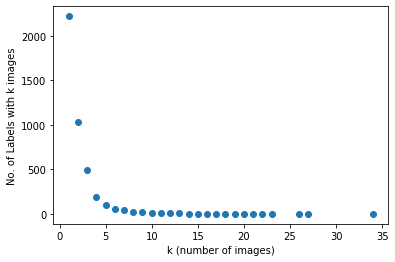

In [6]:
label_counter_dict_no_outlier = dict(Counter(label_counts[label_counts < 800]))

plt.scatter(x=label_counter_dict_no_outlier.keys(),y = label_counter_dict_no_outlier.values())
plt.xlabel('k (number of images)')
plt.ylabel('No. of Labels with k images')


There is roughly about fifteen labels with more than 5 images each, 2300 plus with 1 image each, and 1000 labels with 3 each. This is quite skewed. Ideally we would like to see several points clumped together on the lower right corner of our plot; meaning we have substantially more images than labels. But here we have exactly the opposite.

We would like to have at least five images per label. In order to fix this problem we must perform data augmentation on those labels that have fewer than five images. There is roughly 2 images per species. We perform data augmentation to increase the number of training images (i.e. shear, translate, etc.) This way our model will have more data to work with. Keras has a nice builtin data augmentation and pre-processing module class called `ImageDataGenerator`. We will use this class to generate altered versions of images, especially those that are not in labeled groups of five or more as we discussed earlier

## Image Augmentation

Let's augment the following image by applying shear and other transformations.

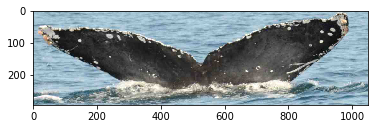

In [7]:
img_dir = 'train/d6c64ee5.jpg'
img = load_img(img_dir)
plt.imshow(img)

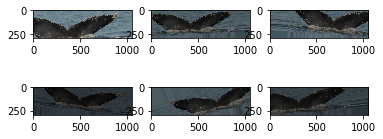

In [8]:
from keras.preprocessing.image import ImageDataGenerator

x = img_to_array(img)
image_batch = x.reshape((1,) + x.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.0],
    zoom_range=0.2)

#create iterator and generate 9 images
it = datagen.flow(image_batch, batch_size=1)
# generate samples and plot
for i in range(6):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()


We will augment our data methodically by choosing those labels with few images. We would ideally want our single image labels to have at least 8 images each. We first organize our images into separate directories given by distinct labels. First create a dictionary to map image filenames to their respective labels.

In [9]:
img_to_lbl = dict(zip(train_labels['Image'],train_labels['Id']))

In [10]:
import os
import shutil

for image in os.listdir('train'):
    #create directory if does not exist
    if image.endswith('jpg'):
        new_direc = os.path.join('train',img_to_lbl[image])
        if not os.path.exists(new_direc):
            os.mkdir(new_direc)    
        #move image to directory with corresponding label
        shutil.move(os.path.join("train",image), new_direc)

Let's check we have created new directories.

In [11]:
len(os.listdir('train'))

4251

Next we write a function that counts the number of images in our directory as well as a method that plots a scatter graph for the lable image distribution. This will be handy later on to verify the number of images after augmentation.

In [12]:
from collections import Counter

def count_ims(path):
    count = 0
    for lbl_dir in os.listdir(path):
        if lbl_dir == 'new_whale' or lbl_dir.startswith('w_'):
            inner_dir = os.path.join(path,lbl_dir)
            for img_name in os.listdir(inner_dir):
                if img_name.endswith('jpg'): count += 1
    return count

def plot_scatter(path):
    my_list = []
    for lbl_dir in os.listdir(path):
        if lbl_dir.startswith('w_'): my_list.append(len(os.listdir(os.path.join(path,lbl_dir))))

    counter_no_outlier = Counter([x for x in my_list if x < 800])

    plt.scatter(x=counter_no_outlier.keys(),y = counter_no_outlier.values())
    plt.xlabel('k (number of images)')
    plt.ylabel('No. of Labels with k images')


Let's check both helper methods.

In [13]:
count_ims('train')

9850

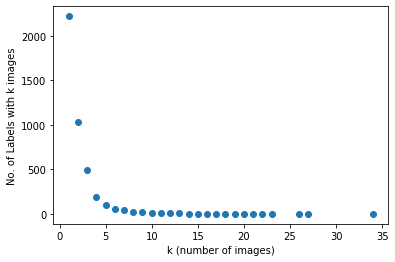

In [14]:
plot_scatter('train')

This verifies the `9850` images in our train directory and the same distribution excluding the outlier.

### Generating a Validation Set

As the reader has noticed, kaggle does not provide a separate validation set with labels but only a test set without labels intended for competition submission. 

We generate a validation set by taking one fourth of the images in each labeled folder and moving it to labeled directories inside a new `validation` directory. We achieve this in a couple of steps:

<ul>
    <li> We generate enough altered copies for each directory of five or fewer images so that there are 8 left for each label in the train directory </li>
    <li> Randomly choose one-fourth of images in the folder and move to directory </li>
</ul>


In [15]:
if not os.path.exists('validation'):
    os.mkdir('validation')

In [16]:
import random
from math import ceil

#we want to augment images depending on directory size
#that is, for directories with one image each we want to augment 7 times
#while for directories with two images we want to augment 3 times and so forth.

def augment_val(label_size, no_copies):
    datagen_val = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    for lbl_dir in os.listdir('train'):
        if lbl_dir.startswith('w_') and len(os.listdir(os.path.join('train',lbl_dir))) == label_size:
            inner_dir = os.path.join('train',lbl_dir)
            for img_name in os.listdir(inner_dir):
                if img_name.endswith('jpg'):
                    #make 5 extra altered copies
                    img_dir = os.path.join(inner_dir,img_name)
                    img = load_img(img_dir)  
                    x = img_to_array(img)  
                    x = x.reshape((1,) + x.shape)  

                    i = 0
                    for batch in datagen_val.flow(x, batch_size=1,
                                              save_to_dir=inner_dir, save_prefix= img_name[:-4], save_format='jpg'):
                        i += 1
                        if i > no_copies - 1:
                            break
            #create folder validation/lbl_dir
            new_dir = os.path.join('validation',lbl_dir)
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)

            #randomly choose 1/4 of images in folder train/lbl_dir and move to validation/lbl_dir
            my_list = os.listdir(inner_dir)
            random_fourth = random.sample(my_list, ceil(len(my_list)/4))

            for img_name in random_fourth:
                img_dir = os.path.join(inner_dir,img_name)
                shutil.move(img_dir, new_dir)

In [17]:
augment_val(1,7)
augment_val(2,3)
augment_val(3,2)
augment_val(4,1)
augment_val(5,1)
augment_val(6,1) #run this line first
augment_val(7,1)

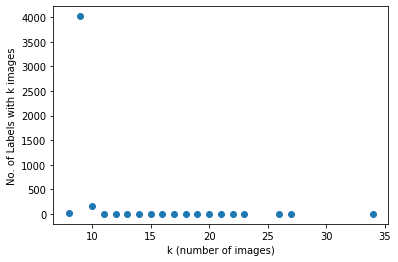

In [18]:
plot_scatter('train')

The next step here is to move a fourth of the content from directories with 8 to 14 images each to validation. Here we don't augment.

In [19]:
def migrate_rand(label_size):
    for lbl_dir in os.listdir('train'):
        if lbl_dir.startswith('w_') and len(os.listdir(os.path.join('train',lbl_dir))) == label_size:
            inner_dir = os.path.join('train',lbl_dir)
            #create folder validation/lbl_dir
            new_dir = os.path.join('validation',lbl_dir)
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)

            #randomly choose 1/4 of images in folder train/lbl_dir and move to validation/lbl_dir
            my_list = os.listdir(inner_dir)
            random_fourth = random.sample(my_list, ceil(len(my_list)/4))

            for img_name in random_third:
                img_dir = os.path.join(inner_dir,img_name)
                shutil.move(img_dir, new_dir)

In [20]:
for i in range(8,35): 
    migrate_rand(i)

Let's check the count for validation labels.

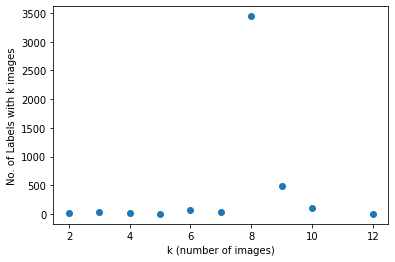

In [21]:
plot_scatter('validation')

Now let's check our train directory to see we have fewer images per label.

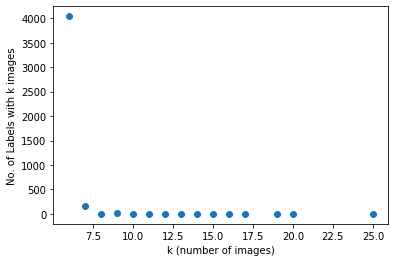

In [22]:
plot_scatter('train')

Before training our model on the whole set, we will start with a smaller subset of 500 labels, chosen randomly as shown below. First, we create the subset directories.

In [34]:
sub_train_dir = 'sub_train'
sub_validation_dir = 'sub_validation'

if not os.path.exists(sub_train_dir):
    os.mkdir(sub_train_dir)
    
if not os.path.exists(sub_validation_dir):
    os.mkdir(sub_validation_dir)

In [35]:
def copy2dir_rand(source, destination, rand_sub):
    for direc in rand_sub:
        if direc.startswith('w_'):
            source_dir = os.path.join(source,direc)
            dest_dir = os.path.join(destination,direc)
            if not os.path.exists(dest_dir):
                    os.mkdir(dest_dir)
            for img_name in os.listdir(source_dir): 
                shutil.copy2(os.path.join(source_dir,img_name), dest_dir)


In [36]:
random.seed(42)
random_subset = random.sample(os.listdir('validation'),500)

In [37]:
copy2dir_rand('train',sub_train_dir,random_subset)
copy2dir_rand('validation',sub_validation_dir,random_subset)

Let's check on the number of mages in each folder.

In [38]:
count_ims(sub_train_dir)

3048

In [39]:
count_ims(sub_validation_dir)

4013

## Transfer Learning

We create latent vectors from our pre-trained keras model VGG16.

In [40]:
from keras.applications import VGG16


vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [46]:
train_dir = sub_train_dir
validation_dir = sub_validation_dir

nTrain = count_ims(sub_train_dir)
nVal = count_ims(sub_validation_dir)


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 50
 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 3048 images belonging to 500 classes.
Found 4013 images belonging to 500 classes.


In [47]:
def generate_features(generator, nImages, batch_size):
    
    features = np.zeros(shape=(nImages, 7, 7, 512))
    labels = np.zeros(shape=(nImages,500))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg_conv.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= nImages:
            break         

    features = np.reshape(features, (nImages, 7 * 7 * 512))
    
    return features, labels

In [48]:
train_features, train_labels = generate_features(train_generator, nTrain, batch_size)

In [49]:
val_features, val_labels = generate_features(validation_generator, nVal, batch_size)

## Siamese Neural Network

The one feature that characterizes Siamese Neural Networks (SNNs), unlike other deep neural networks, is the existence of two distinct inputs at the head of the network. Moreover, we don't use two separate sets of weights to learn from these two inputs but the same one is applied to both.

In [437]:
#second run

model = Sequential()

model.add(Dense(
        526, 
        activation='sigmoid',
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=100**-0.5),
        kernel_regularizer=l2(alpha),
        input_dim = 7*7*512
    )
)

input_shape = (7 * 7 * 512,)

left_input = Input(input_shape)
left_top = model(left_input)

right_input = Input(input_shape)
right_top = model(right_input)

#merge layers and compute the l1 distance
subtracted = keras.layers.subtract([left_top,right_top])
absolute = Lambda(lambda x: K.abs(x))(subtracted)

prediction = Dense(1,activation='sigmoid')(absolute)
snn = Model(input=[left_input,right_input],output=prediction)

optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
snn.compile(loss="binary_crossentropy",optimizer=optimizer)
snn.count_params()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


13197341

## Batch Processing (Image Pairs)

Recall we have a handful of images to work with. The minimum train label size is 6 while validation label size is 2. Due to limiting computing resources and time this is the best we can do.

Our siamese neural net above takes in a pair of inputs and classifies it as `1` if the inputs belong to the same label and `0` if not. The following helper function creates a batch of `n` pairs (half of the same label and half of a different label).

In [288]:
def get_batch(features, labels, n):
    """arg: dataset refers to train or validation; batch size will differ
       return: pairs and labels
    """  
    lbl_set = np.apply_along_axis(lambda x: np.argmax(x), 1, labels)

    rand_lbls = rng.choice(list(set(lbl_set)),size=(n,),replace=False)

    #for a fixed set of labels, we can find the offset of features in
    #train_feat
    pairs=[np.zeros((n, 7 * 7 * 512)) for i in range(2)]
    targets=np.zeros((n,))
    targets[n//2:] = 1
    for i in range(n):
        cat = rand_lbls[i]
        #find index corresp. to random item from rand_lbls
        #use numpy to extract indices
        cat_indices = np.where(lbl_set == cat)[0]
        #choose two random indices
        rand_indices = rng.choice(cat_indices,2)

        pairs[0][i,:] = features[rand_indices[0]]

        #for the first half, choose images with a different label
        #and images with same label for the second
        if i < n//2: 
            cat_indices_comp = np.where(labels != cat)[0]
            rand_indices_comp = rng.choice(cat_indices_comp,1)
            pairs[1][i,:] = features[rand_indices_comp[0]]  
        else:
            pairs[1][i,:] = features[rand_indices[1]]

    return pairs, targets

### One-Shot Accuracy

Validation and train accuracy are not computed in the usual way. Following the results of the paper mentioned at the beginning of the notebook we compute what is referred to as N-way one-shot accuracy. This is simply choosing one label and comparing it to `N-1` images with a different label and with itself. The following helper function does just that.

In [438]:
def oneshot_task(N, features, labels):

    lbl_set = np.apply_along_axis(lambda x: np.argmax(x), 1, labels)
    
    rand_lbls = rng.choice(list(set(lbl_set)),size=(N,),replace=False)
    cat = rand_lbls[0]
    cat_indices = np.where(lbl_set == cat)[0]
    
    ex1, ex2 = rng.choice(cat_indices,2)
    test_image = np.asarray(list(features[ex1])*N).reshape((N,features.shape[1]))
    
    cat_indices_comp = np.where(lbl_set != cat)[0]
    rand_indices_comp = rng.choice(cat_indices_comp,N)
    support_set = features[rand_indices_comp]
    support_set[0] = features[ex2]
    
    pairs = [test_image,support_set]
    targets = np.zeros((N,))
    targets[0] = 1
    
    
    return pairs, targets
    
    
def oneshot_acc(model,N,n_classes,features,labels):
    pass
    n_correct = 0
    for i in range(n_classes):
        inputs, targets = oneshot_task(N,features,labels)
        probs = model.predict(inputs)
        if np.argmax(probs) == 0:
            n_correct+=1
    percent_correct = (100.0*n_correct / n_classes)
    return percent_correct


## Model Training

Unlike a typical neural network, we don't have that many images to work with. at our disposal, there is only a handful of images in both our training and validation sets. In order to adequately learn the weights, we must do enough iterations to cover all of possible pairings. Let's do a quick count of how many pairings we should be looking at. <br>

There are two different kinds of pairings. Same class pairings and different class pairings, which we denote by $P_{=}$ and $P_{\neq}$. On average, there are 6 images per label.

$$P_{=} = {6 \choose 2}  \times 500 = 7500$$

$$P_{\neq} =  {500 \choose 2}  \times   6 \times 6  = 4491000$$

The total number of pairings comes to about 4.5 million, of which, $P_{=}$ is `0.16` percent. Clearly, having more images per label, would increase this proportion, but, for practical purposes, we will implement a batching procedure that takes on the same number of same label pairings as different label pairings.

Ideally, with enough coputing power, we can train our model using the same siamese network but with a weighted binary cross entropy loss towards the value `0` (since most pairings come from different labels).

In [322]:
from keras.models import load_model
# snn = load_model('model.h5')

loss_every=15
batch_train_size = 6
N_way = 20
n_classes = 100
 
loss_values = []
train_acc_values = []
val_acc_values = []


#400 iterations is not enough to cover all of possible pairings
#However, due to limiting computing power and memory, this is the
#best we can do.

for i in range(400):
    inputs, targets = get_batch(train_features, train_labels, batch_train_size)
    loss=snn.train_on_batch(inputs,targets)
    
    train_acc = oneshot_acc(snn,N_way,n_classes,train_features,train_labels) 
    val_acc = oneshot_acc(snn,N_way,n_classes,val_features,val_labels) 
    
    if i % loss_every == 0:
        loss_values.append(loss)
        train_acc_values.append(train_acc)
        val_acc_values.append(val_acc)

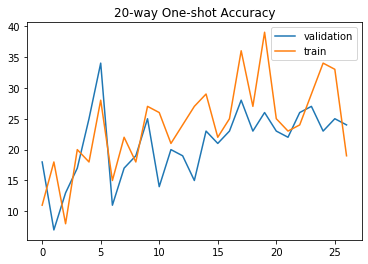

In [441]:
plt.plot(val_acc_values, label = 'validation')
plt.plot(train_acc_values, label = 'train')
plt.legend(loc = 'upper right')
plt.title('20-way One-shot Accuracy')
plt.show()

As we can see in the plot above, our model suffers from high variance even though there is an overall positive trend. Since we computed feature vectors and only added a top layer to the `VGG` model, we didn't have the flexibility in adjusting our weights to account for transformations such as translation and shearing. Given more computing power, we could freeze all layers of our `VGG` except for the last two or three sets of convolution and pooling layer pairs and retrain our SNN. For instance, we may replace `model` with `model_2` below:


```vgg_conv_2 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
for layer in vgg_conv_2.layers[:-2]:
    layer.trainable = False   
for layer in vgg_conv_2.layers:
    print(layer, layer.trainable)
model_2 = Sequential()
model_2.add(vgg_conv_2)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(1024, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(840, activation='softmax'))
```

### How to classify `new_whale` flukes?

We have already done this part in the implementation of `oneshot_task`. For instance, if we wish to predict whether an image is `new_whale` as opposed to any of the identified whale fluke images all we do is set a threshold.

The image below was not used in training our model. So, most likely than not, our model will predict `new_whale` when given this example.

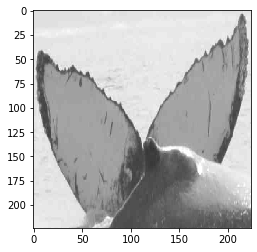

In [374]:
filename = 'train/w_015c991/dee86ff3.jpg'
# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
plt.imshow(original)

In [445]:
def predict_label_probs(features, labels, filename):
    
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = numpy_image.reshape((1,) + numpy_image.shape)
    vgg_prediction = vgg_conv.predict(image_batch)
    test_im = vgg_prediction.reshape(len(vgg_prediction), 7 * 7 * 512) 
    
    lbl_set = np.apply_along_axis(lambda x: np.argmax(x), 1, labels)
    test_image = np.asarray(list(test_im[0])*500).reshape((500,features.shape[1]))
    
    unique_features = np.array([np.where(lbl_set == i)[0][0] for i in range(500)])
    support_set = features[unique_features]
    
    pairs = [test_image,support_set]   
    probs = list(map(lambda x: x[0],snn.predict(pairs)))
    
    return list(zip(probs,list(train_generator.class_indices.keys())))

In [447]:
def predict(filename, threshold = 0.5):
    probs_labels = predict_label_probs(train_features, train_labels, filename)
    
    probs = np.array([a for a,b in probs_labels])
    labels = [b for a,b in probs_labels]
    
    max_prob_ind = np.argmax(probs)
    
    max_prob = probs[max_prob_ind]
    if max_prob > threshold: return labels[max_prob_ind]
    
    else: return 'new_whale'
    

In [451]:
predict(filename,0.6)

'new_whale'

In [452]:
snn.save('model.h5')